In [ ]:
# # 원데이터 가져오기
# import kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [3]:
# raw data
origin_dataset = "/content/drive/MyDrive/AI 엔지니어 과정/Part 2/초급_프로젝트_0715~0731/데이터/프로젝트 raw data/ai03-level1-project.zip"

In [4]:
# bbox, anno 내가 만든 전처리 데이터
dataset = "/content/drive/MyDrive/AI 엔지니어 과정/Part 2/초급_프로젝트_0715~0731/데이터/Personal_Fully Annotating_Bounding Boxing/unzipped.zip"

In [12]:
# 없는 labeling 생성 데이터(1팀 전체 전처리 데이터셋)
fully_dataset = "/content/drive/MyDrive/AI 엔지니어 과정/Part 2/초급_프로젝트_0715~0731/데이터/영은님 전처리 완성: 전처리 + 증강 이미지 포함/real_team1_pill_images.zip"


In [5]:
# 파일 압축해제
import zipfile
import os

# 압축 해제 경로
extract_dir = "/content/"

with zipfile.ZipFile(origin_dataset, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("압축해제 완료")

압축해제 완료


In [6]:
# 압축 해제 경로
extract_dir = "/content/labeling_dataset"

with zipfile.ZipFile(dataset, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("압축해제 완료")

압축해제 완료


In [13]:
# 압축 해제 경로
extract_dir = "/content/fully_processing_dataset"

with zipfile.ZipFile(fully_dataset, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("압축해제 완료")

압축해제 완료


In [14]:
!ls

 drive			    labeling_dataset   sample_data
 fully_processing_dataset  ' origin_dataset'


In [8]:
# matplotlib 캐시 폴더 삭제(자동으로 재성성됨)
import os
import shutil
import matplotlib

cache_dir = matplotlib.get_cachedir()
shutil.rmtree(cache_dir)
print("matplotlib 캐시 삭제 완료 : ", cache_dir)

matplotlib 캐시 삭제 완료 :  /root/.cache/matplotlib


In [9]:
# 한글폰트 사용 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore')

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)

fm.fontManager.addfont(path)



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 8s (1,317 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126284 files and dire

In [10]:
import matplotlib.font_manager as fm
for f in fm.findSystemFonts():
    if 'Nanum' in f:
        print(f)

/usr/share/fonts/truetype/nanum/NanumBarunGothic-YetHangul.ttf
/usr/share/fonts/truetype/nanum/NanumMyeongjo-YetHangul.ttf
/usr/share/fonts/truetype/nanum/NanumBarunpenB.ttf
/usr/share/fonts/truetype/nanum/NanumSquare_acEB.ttf
/usr/share/fonts/truetype/nanum/NanumSquareL.ttf
/usr/share/fonts/truetype/nanum/NanumMyeongjoEco.ttf
/usr/share/fonts/truetype/nanum/NanumSquareRoundL.ttf
/usr/share/fonts/truetype/nanum/NanumMyeongjoEcoBold.ttf
/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf
/usr/share/fonts/truetype/nanum/NanumGothicLight.ttf
/usr/share/fonts/truetype/nanum/NanumSquareB.ttf
/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf
/usr/share/fonts/truetype/nanum/NanumBarunGothicUltraLight.ttf
/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf
/usr/share/fonts/truetype/nanum/NanumSquareEB.ttf
/usr/share/fonts/truetype/nanum/NanumSquareRoundEB.ttf
/usr/share/fonts/truetype/nanum/NanumGothicEcoR.ttf
/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf
/usr/share/font

In [11]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [ ]:
# # device 설정
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 라벨링이 존재하지 않는 데이터 불러오기(raw data로)

import os
import json
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 디렉토리 설정
annotation_root = '/content/train_annotations'
image_root = '/content/train_images'

# 1. 모든 하위 json 파일 찾기 (재귀 탐색)
all_json_paths = []
for root, dirs, files in os.walk(annotation_root):
    for file in files:
        if file.endswith('.json'):
            all_json_paths.append(os.path.join(root, file))

if not all_json_paths:
    raise FileNotFoundError(".json 어노테이션 파일을 찾을 수 없습니다.")

# 2. 랜덤하게 하나 선택
chosen_json_path = random.choice(all_json_paths)

# 3. JSON 로드
with open(chosen_json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 4. 카테고리 및 이미지 정보 추출
categories = {cat['id']: cat['name'] for cat in data['categories']}
images = data['images']
annotations = data['annotations']

# 5. 이미지 랜덤 선택
random_img_info = random.choice(images)
image_id = random_img_info['id']
image_filename = random_img_info['file_name']
image_path = os.path.join(image_root, image_filename)

# 6. 이미지 열기
image = Image.open(image_path)

# 7. 시각화
fig, ax = plt.subplots(1, figsize=(8, 10))
ax.imshow(image)
ax.set_title(f"Image: {image_filename} | JSON: {os.path.basename(chosen_json_path)}")

# 8. 해당 image_id의 bbox만 시각화
for ann in annotations:
    if ann['image_id'] != image_id:
        continue

    x, y, w, h = ann['bbox']
    category_id = ann['category_id']
    label = categories.get(category_id, f"id:{category_id}")

    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y - 10, label, fontsize=10, color='white', backgroundcolor='red')

plt.axis('off')
plt.tight_layout()
plt.show()

In [15]:
import os
import json
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 이미지 및 어노테이션 경로 설정
image_path = '/content/fully_processing_dataset/K-001900-010224-016551-031705/K-01224.png'  # 이미지 확장자를 .png로 가정
annotation_path = '/content/fully_processing_dataset/K-001900-010224-016551-031705/K-01224.json' # 어노테이션 파일 경로

# 이미지 열기
try:
    image = Image.open(image_path)
except FileNotFoundError:
    print(f"이미지 파일을 찾을 수 없습니다: {image_path}")
    # 이미지 확장자가 다를 수 있으므로, 다른 확장자로도 시도해봅니다.
    base_path, _ = os.path.splitext(image_path)
    for ext in ['.jpg', '.jpeg', '.bmp']:
        new_path = base_path + ext
        try:
            image = Image.open(new_path)
            image_path = new_path
            print(f"이미지를 찾았습니다: {image_path}")
            break
        except FileNotFoundError:
            continue
    else:
        print("모든 확장자(.png, .jpg, .jpeg, .bmp)에 대해 이미지를 찾지 못했습니다.")


# 어노테이션 파일 열기
try:
    with open(annotation_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
except FileNotFoundError:
    print(f"어노테이션 파일을 찾을 수 없습니다: {annotation_path}")
    data = None

# 시각화
if 'image' in locals() and data:
    fig, ax = plt.subplots(1, figsize=(8, 10))
    ax.imshow(image)
    ax.set_title(f"Image: {os.path.basename(image_path)}")

    # 카테고리 정보 추출
    categories = {cat['id']: cat['name'] for cat in data.get('categories', [])}

    # 어노테이션 정보 추출 및 bbox 시각화
    for ann in data.get('annotations', []):
        x, y, w, h = ann['bbox']
        category_id = ann['category_id']
        label = categories.get(category_id, f"id:{category_id}")

        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 10, label, fontsize=10, color='white', backgroundcolor='lime')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

이미지 파일을 찾을 수 없습니다: /content/fully_processing_dataset/K-001900-010224-016551-031705/K-01224.png
모든 확장자(.png, .jpg, .jpeg, .bmp)에 대해 이미지를 찾지 못했습니다.
어노테이션 파일을 찾을 수 없습니다: /content/fully_processing_dataset/K-001900-010224-016551-031705/K-01224.json


In [16]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def find_file(root_dir, file_name):
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.startswith(file_name):
                return os.path.join(root, file)
    return None

# 파일 찾기
image_filename_base = "K-01224"
image_path = find_file('/content/fully_processing_dataset', image_filename_base)

if image_path is None:
    print(f"'{image_filename_base}'로 시작하는 파일을 찾을 수 없습니다.")
else:
    print(f"이미지 파일을 찾았습니다: {image_path}")

    # 어노테이션 파일 경로 생성 (이미지와 이름이 같고 확장자만 .json으로 다름)
    annotation_path = os.path.splitext(image_path)[0] + '.json'

    # 이미지 열기
    image = Image.open(image_path)

    # 어노테이션 파일 열기
    try:
        with open(annotation_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"어노테이션 파일을 찾을 수 없습니다: {annotation_path}")
        data = None

    # 시각화
    if data:
        fig, ax = plt.subplots(1, figsize=(8, 10))
        ax.imshow(image)
        ax.set_title(f"Image: {os.path.basename(image_path)}")

        # 카테고리 정보 추출
        categories = {cat['id']: cat['name'] for cat in data.get('categories', [])}

        # 어노테이션 정보 추출 및 bbox 시각화
        for ann in data.get('annotations', []):
            x, y, w, h = ann['bbox']
            category_id = ann['category_id']
            label = categories.get(category_id, f"id:{category_id}")

            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y - 10, label, fontsize=10, color='white', backgroundcolor='lime')

        plt.axis('off')
        plt.tight_layout()
        plt.show()

'K-01224'로 시작하는 파일을 찾을 수 없습니다.


In [17]:
!ls -R /content/fully_processing_dataset

Streaming output truncated to the last 5000 lines.
K-003544-006563-016548-029871_0_2_0_2_75_000_200_aug5_crop0.png
K-003544-006563-016548-029871_0_2_0_2_75_000_200_aug5_crop3.png
K-003544-006563-016548-029871_0_2_0_2_75_000_200_aug5.png
K-003544-006563-016548-029871_0_2_0_2_75_000_200_aug8_crop3.png
K-003544-006563-016548-029871_0_2_0_2_75_000_200_aug8_crop4.png
K-003544-006563-016548-029871_0_2_0_2_75_000_200_aug8.png
K-003544-006563-016548-029871_0_2_0_2_75_000_200.png
K-003544-006563-016551-023203_0_2_0_2_70_000_200_aug0_crop1.png
K-003544-006563-016551-023203_0_2_0_2_70_000_200_aug0_crop2.png
K-003544-006563-016551-023203_0_2_0_2_70_000_200_aug0_crop3.png
K-003544-006563-016551-023203_0_2_0_2_70_000_200_aug0.png
K-003544-006563-016551-023203_0_2_0_2_70_000_200_aug11_crop0.png
K-003544-006563-016551-023203_0_2_0_2_70_000_200_aug11_crop1.png
K-003544-006563-016551-023203_0_2_0_2_70_000_200_aug11_crop2.png
K-003544-006563-016551-023203_0_2_0_2_70_000_200_aug11_crop3.png
K-003544-00656

In [18]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def find_file(root_dir, file_name):
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file == file_name:
                return os.path.join(root, file)
    return None

# 파일 찾기
annotation_filename = "K-001900-010224-031705__70_000_200.json"
annotation_path = find_file('/content/fully_processing_dataset', annotation_filename)

if annotation_path is None:
    print(f"'{annotation_filename}' 파일을 찾을 수 없습니다.")
else:
    print(f"어노테이션 파일을 찾았습니다: {annotation_path}")

    # 이미지 파일 경로 생성 (어노테이션과 이름이 같고 확장자만 다름)
    image_path_base = os.path.splitext(annotation_path)[0]

    image_path = None
    for ext in ['.png', '.jpg', '.jpeg', '.bmp']:
        potential_path = image_path_base + ext
        if os.path.exists(potential_path):
            image_path = potential_path
            break

    if image_path is None:
        print("해당 어노테이션에 대한 이미지 파일을 찾을 수 없습니다.")
    else:
        # 이미지 열기
        image = Image.open(image_path)

        # 어노테이션 파일 열기
        with open(annotation_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # 시각화
        fig, ax = plt.subplots(1, figsize=(8, 10))
        ax.imshow(image)
        ax.set_title(f"Image: {os.path.basename(image_path)}")

        # 카테고리 정보 추출
        categories = {cat['id']: cat['name'] for cat in data.get('categories', [])}

        # 어노테이션 정보 추출 및 bbox 시각화
        for ann in data.get('annotations', []):
            x, y, w, h = ann['bbox']
            category_id = ann['category_id']
            label = categories.get(category_id, f"id:{category_id}")

            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y - 10, label, fontsize=10, color='white', backgroundcolor='lime')

        plt.axis('off')
        plt.tight_layout()
        plt.show()

'K-001900-010224-031705__70_000_200.json' 파일을 찾을 수 없습니다.


In [19]:
import os

def find_file(root_dir, file_name):
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file == file_name:
                return os.path.join(root, file)
    return None

# 파일 찾기
txt_filename = "K-001900-010224-031705__70_000_200.txt"
txt_path = find_file('/content/fully_processing_dataset', txt_filename)

if txt_path is None:
    print(f"'{txt_filename}' 파일을 찾을 수 없습니다.")
else:
    print(f"파일을 찾았습니다: {txt_path}")
    with open(txt_path, 'r') as f:
        print(f.read())

'K-001900-010224-031705__70_000_200.txt' 파일을 찾을 수 없습니다.


In [20]:
!ls /content/fully_processing_dataset/labels/train_images/
!ls /content/fully_processing_dataset/labels/val_images/

K-001900-010224-016551-031705_0_2_0_2_70_000_200_aug0_crop0.txt
K-001900-010224-016551-031705_0_2_0_2_70_000_200_aug0_crop1.txt
K-001900-010224-016551-031705_0_2_0_2_70_000_200_aug0_crop2.txt
K-001900-010224-016551-031705_0_2_0_2_70_000_200_aug0_crop3.txt
K-001900-010224-016551-031705_0_2_0_2_70_000_200_aug0_crop4.txt
K-001900-010224-016551-031705_0_2_0_2_70_000_200_aug0.txt
K-001900-010224-016551-031705_0_2_0_2_70_000_200_aug10_crop0.txt
K-001900-010224-016551-031705_0_2_0_2_70_000_200_aug10_crop1.txt
K-001900-010224-016551-031705_0_2_0_2_70_000_200_aug10_crop4.txt
K-001900-010224-016551-031705_0_2_0_2_70_000_200_aug10.txt
K-001900-010224-016551-031705_0_2_0_2_70_000_200_aug11_crop2.txt
K-001900-010224-016551-031705_0_2_0_2_70_000_200_aug11.txt
K-001900-010224-016551-031705_0_2_0_2_70_000_200_aug12_crop1.txt
K-001900-010224-016551-031705_0_2_0_2_70_000_200_aug12_crop3.txt
K-001900-010224-016551-031705_0_2_0_2_70_000_200_aug12.txt
K-001900-010224-016551-031705_0_2_0_2_70_000_200_aug13_

In [21]:
with open('/content/fully_processing_dataset/labels/train_images/K-001900-010224-016551-031705_0_2_0_2_70_000_200.txt', 'r') as f:
    print(f.read())

60 0.262807 0.262500 0.251025 0.332813
24 0.725922 0.278125 0.292008 0.351562
0 0.768443 0.732812 0.215164 0.123438
14 0.289810 0.754526 0.219278 0.307774



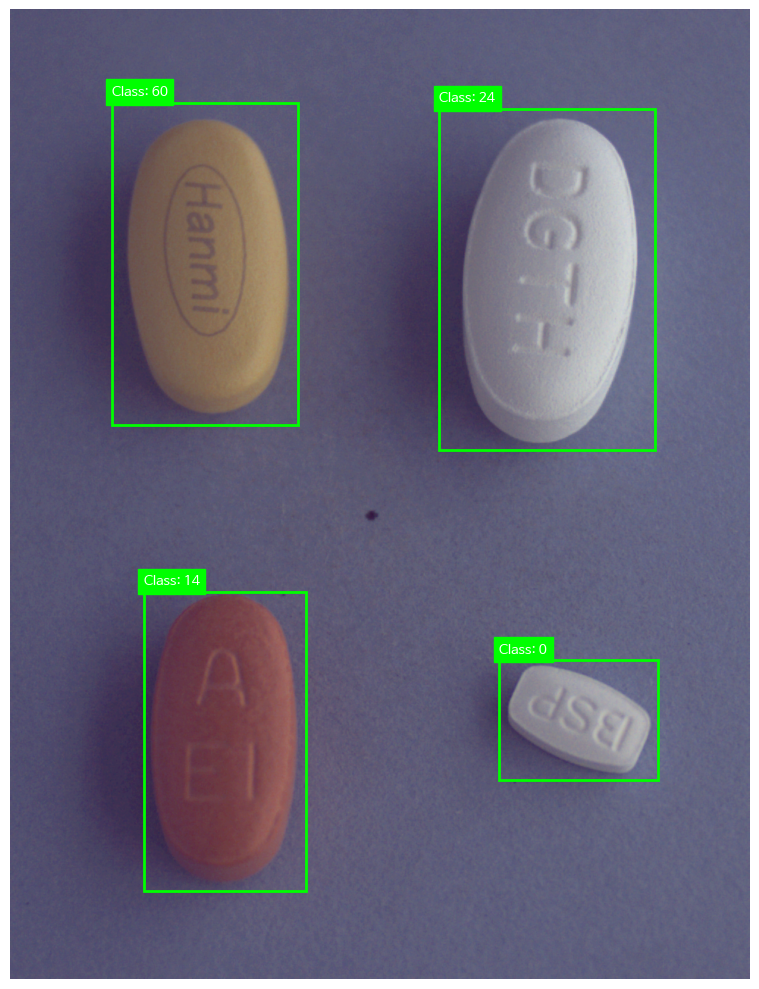

In [22]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 이미지 및 라벨 경로 설정
image_dir = '/content/fully_processing_dataset/images/train_images/'
label_path = '/content/fully_processing_dataset/labels/train_images/K-001900-010224-016551-031705_0_2_0_2_70_000_200.txt'
image_filename = os.path.splitext(os.path.basename(label_path))[0] + '.png' # Assuming image is png
image_path = os.path.join(image_dir, image_filename)

# 이미지 열기
try:
    image = Image.open(image_path)
    width, height = image.size

    # 라벨 파일 읽기
    with open(label_path, 'r') as f:
        lines = f.readlines()

    # 시각화
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center = float(parts[1])
        y_center = float(parts[2])
        w = float(parts[3])
        h = float(parts[4])

        # YOLO 좌표를 일반 좌표로 변환
        x1 = (x_center - w / 2) * width
        y1 = (y_center - h / 2) * height
        w_px = w * width
        h_px = h * height

        rect = patches.Rectangle((x1, y1), w_px, h_px, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 10, f'Class: {class_id}', color='white', backgroundcolor='lime')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"이미지 파일을 찾을 수 없습니다: {image_path}")

In [24]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def find_file(root_dir, file_name_prefix):
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            # Check if the file name starts with the prefix and contains "_000_200"
            if file.startswith(file_name_prefix) and "_000_200" in file:
                # Further check for common image extensions
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    return os.path.join(root, file)
    return None

# 원본 이미지 파일 이름 접두사
original_image_prefix = "K-001900-010224-016551-031705"

# origin_dataset 경로
origin_dir = "/content/train_images" # 압축 해제된 경로를 사용

# 파일 찾기
original_image_path = find_file(origin_dir, original_image_prefix)

if original_image_path is None:
    print(f"'{original_image_prefix}'로 시작하는 원본 이미지 파일을 찾을 수 없습니다.")
else:
    print(f"원본 이미지 파일을 찾았습니다: {original_image_path}")

    # 이미지 열기
    image = Image.open(original_image_path)

    # 시각화
    plt.figure(figsize=(8, 10))
    plt.imshow(image)
    plt.title(f"Original Image: {os.path.basename(original_image_path)}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

'K-001900-010224-016551-031705'로 시작하는 원본 이미지 파일을 찾을 수 없습니다.


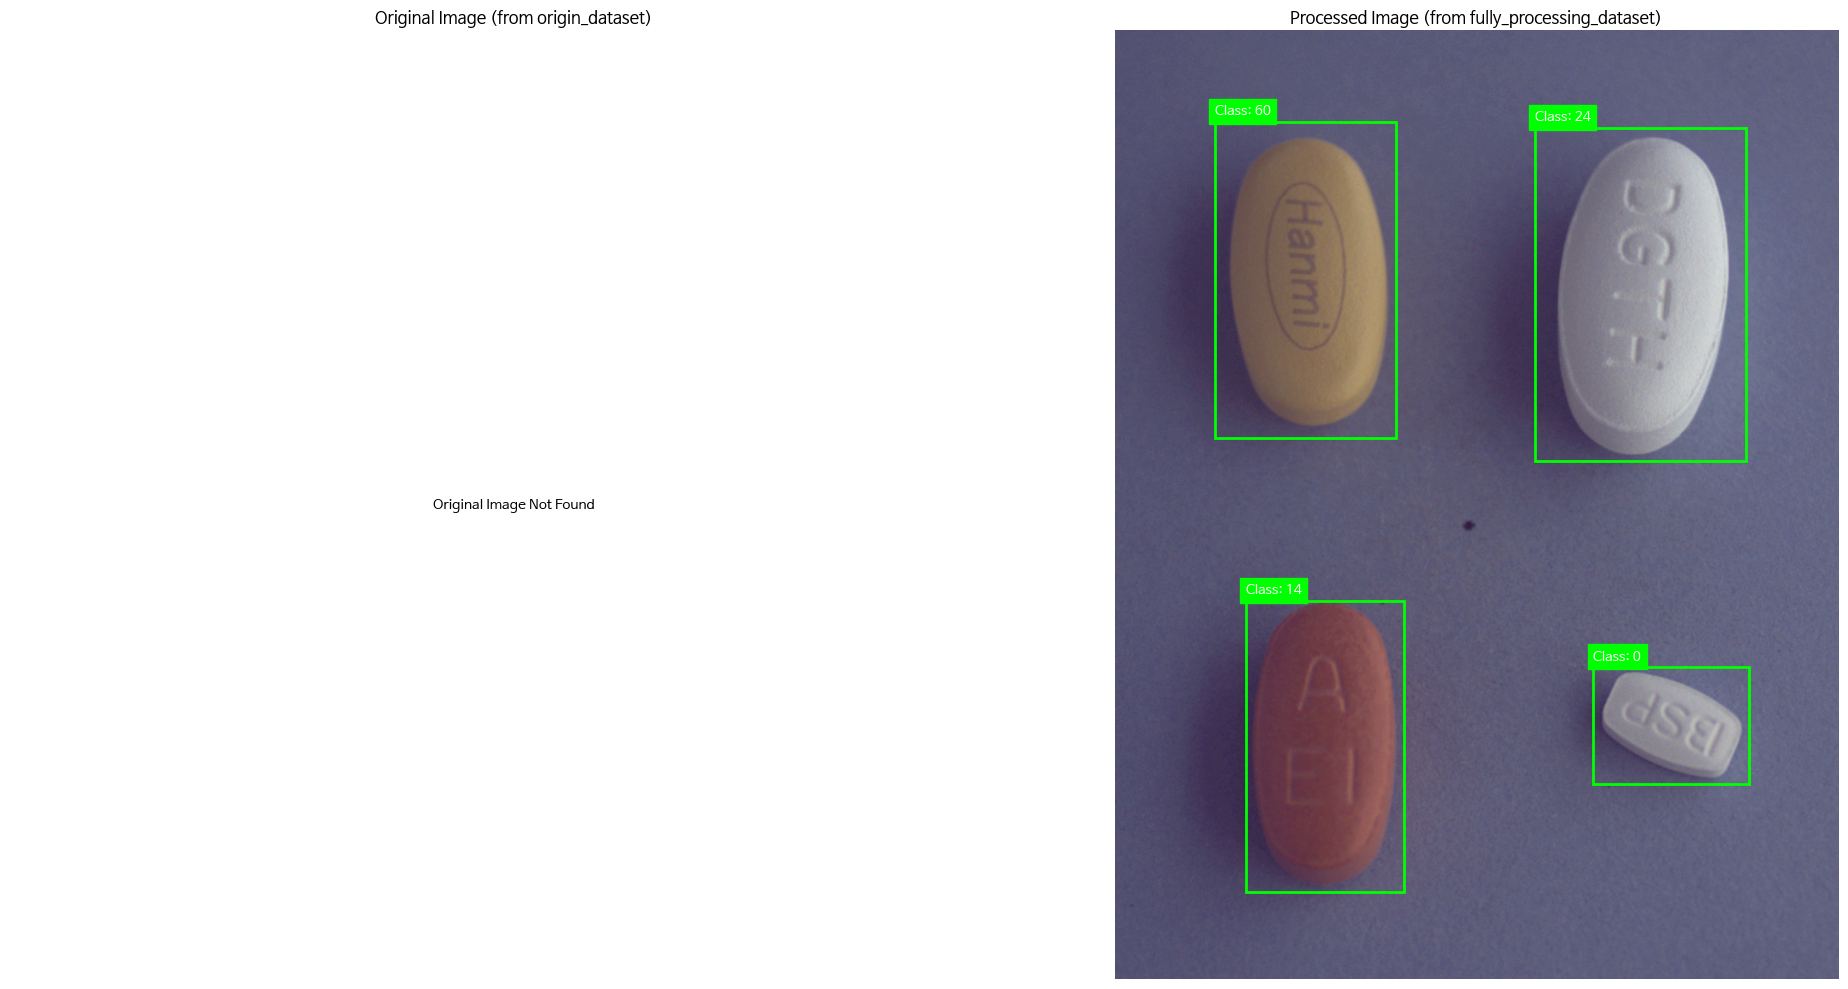

In [25]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- 파일 경로 설정 ---
# 처리된(Processed) 데이터 경로
processed_image_path = '/content/fully_processing_dataset/images/train_images/K-001900-010224-016551-031705_0_2_0_2_70_000_200.png'
label_path = '/content/fully_processing_dataset/labels/train_images/K-001900-010224-016551-031705_0_2_0_2_70_000_200.txt'

# 원본(Original) 데이터 경로
original_image_dir = '/content/train_images'
base_filename = os.path.splitext(os.path.basename(processed_image_path))[0]
original_image_path = None

# 원본 이미지 찾기 (확장자가 다를 수 있으므로 .jpg, .jpeg, .bmp도 확인)
for ext in ['.png', '.jpg', '.jpeg', '.bmp']:
    potential_path = os.path.join(original_image_dir, base_filename + ext)
    if os.path.exists(potential_path):
        original_image_path = potential_path
        break

# --- 시각화 ---
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# 1. 원본 이미지 시각화 (왼쪽)
if original_image_path:
    original_image = Image.open(original_image_path)
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image (from origin_dataset)')
    ax[0].axis('off')
else:
    ax[0].text(0.5, 0.5, 'Original Image Not Found', ha='center', va='center')
    ax[0].set_title('Original Image (from origin_dataset)')
    ax[0].axis('off')


# 2. 처리된 이미지와 BBox 시각화 (오른쪽)
try:
    processed_image = Image.open(processed_image_path)
    width, height = processed_image.size
    ax[1].imshow(processed_image)
    ax[1].set_title('Processed Image (from fully_processing_dataset)')

    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, w, h = map(float, parts[1:])

        # YOLO 좌표 -> 일반 좌표 변환
        x1 = (x_center - w / 2) * width
        y1 = (y_center - h / 2) * height
        w_px = w * width
        h_px = h * height

        rect = patches.Rectangle((x1, y1), w_px, h_px, linewidth=2, edgecolor='lime', facecolor='none')
        ax[1].add_patch(rect)
        ax[1].text(x1, y1 - 10, f'Class: {class_id}', color='white', backgroundcolor='lime')

    ax[1].axis('off')

except FileNotFoundError:
    ax[1].text(0.5, 0.5, 'Processed Image or Label Not Found', ha='center', va='center')
    ax[1].set_title('Processed Image (from fully_processing_dataset)')
    ax[1].axis('off')


plt.tight_layout()
plt.show()

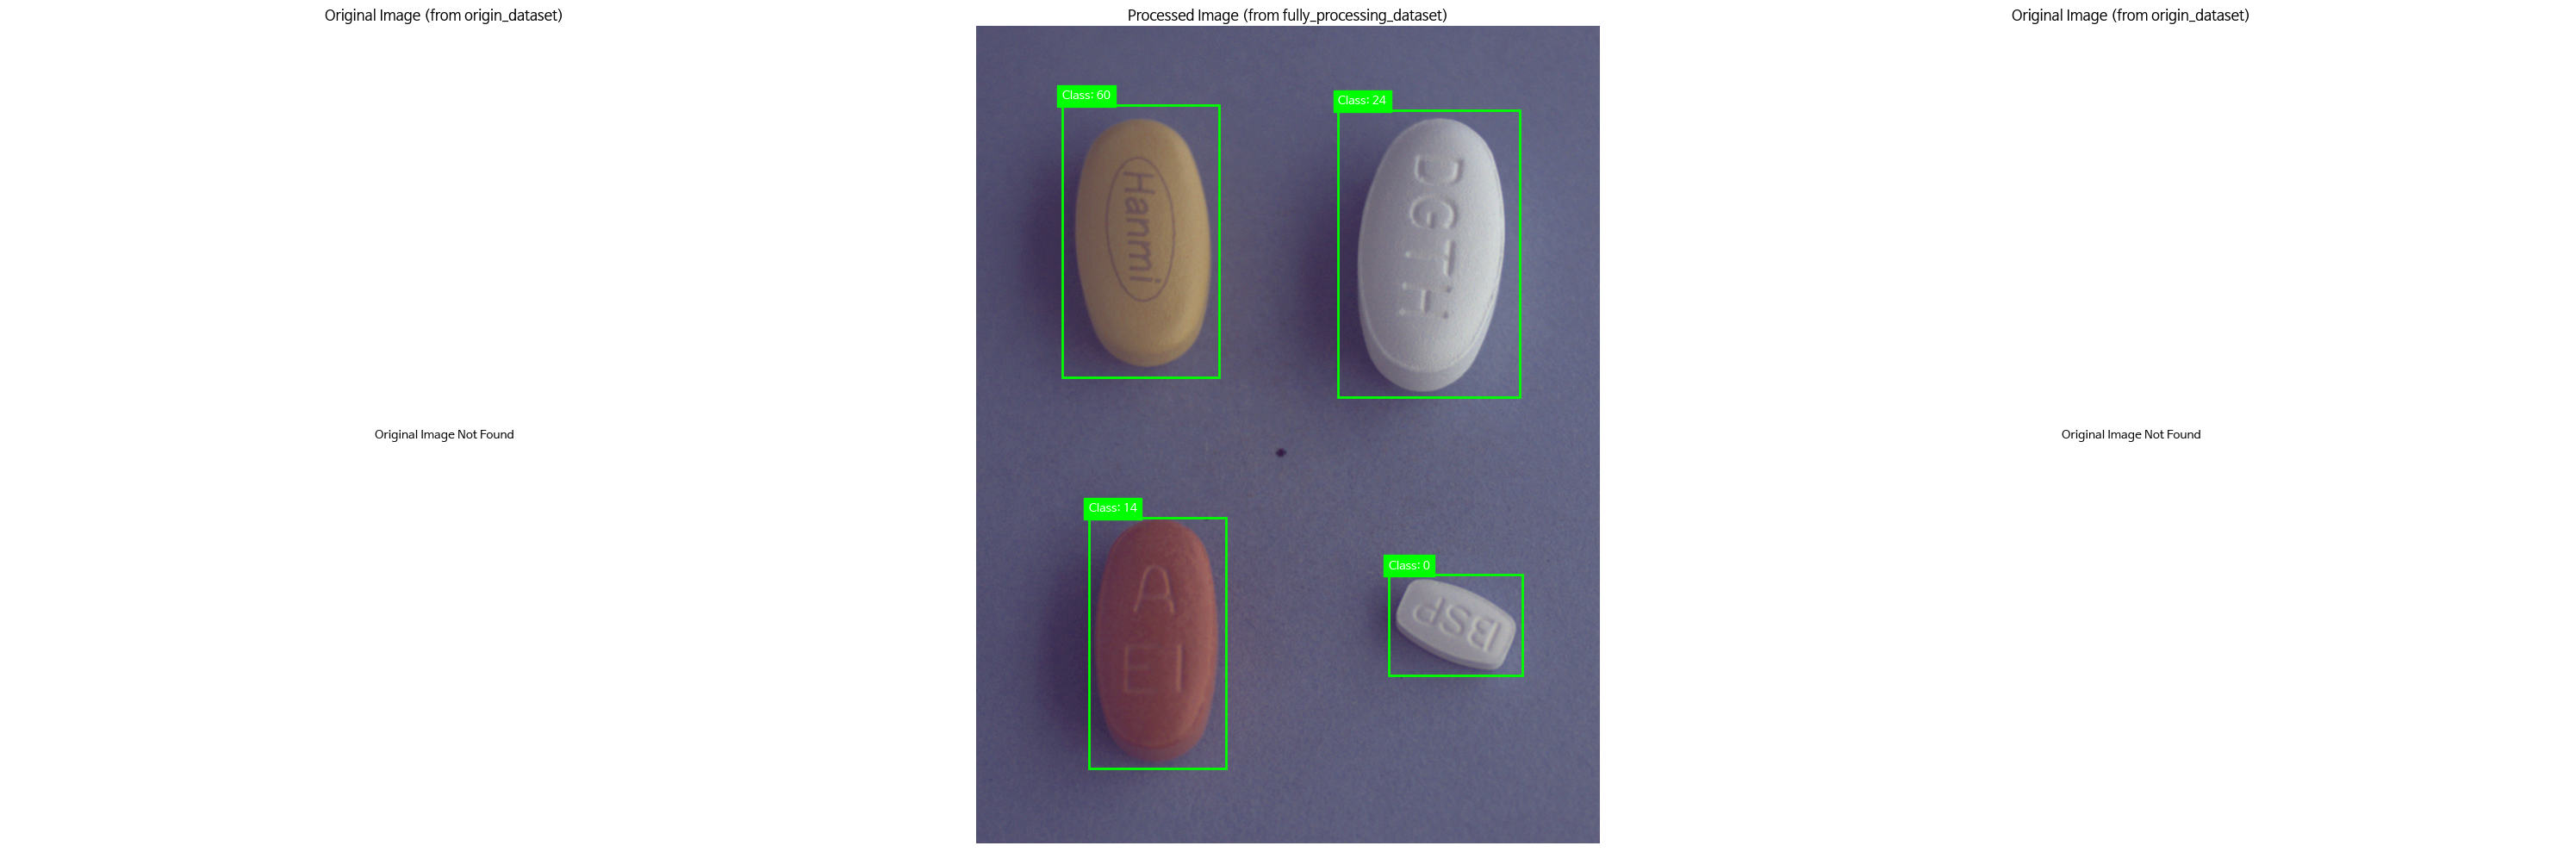

In [28]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- 파일 경로 설정 ---
# 처리된(Processed) 데이터 경로
processed_image_path = '/content/fully_processing_dataset/images/train_images/K-001900-010224-016551-031705_0_2_0_2_70_000_200.png'
label_path = '/content/fully_processing_dataset/labels/train_images/K-001900-010224-016551-031705_0_2_0_2_70_000_200.txt'

# 원본(Original) 데이터 경로
original_image_dir = '/content/train_images'
# 처리된 파일명에서 원본 기본 파일명 추출
base_filename = os.path.splitext(os.path.basename(processed_image_path))[0].split('_')[0]
original_image_path = None

# 원본 이미지 찾기 (확장자가 다를 수 있으므로 .jpg, .jpeg, .bmp도 확인)
for ext in ['.png', '.jpg', '.jpeg', '.bmp']:
    potential_path = os.path.join(original_image_dir, base_filename + ext)
    if os.path.exists(potential_path):
        original_image_path = potential_path
        break

# --- 시각화 ---
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

# 1. 원본 이미지 시각화 (왼쪽)
if original_image_path:
    original_image = Image.open(original_image_path)
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image (from origin_dataset)')
    ax[0].axis('off')
else:
    ax[0].text(0.5, 0.5, 'Original Image Not Found', ha='center', va='center')
    ax[0].set_title('Original Image (from origin_dataset)')
    ax[0].axis('off')


# 2. 처리된 이미지와 BBox 시각화 (가운데)
try:
    processed_image = Image.open(processed_image_path)
    width, height = processed_image.size
    ax[1].imshow(processed_image)
    ax[1].set_title('Processed Image (from fully_processing_dataset)')

    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, w, h = map(float, parts[1:])

        # YOLO 좌표 -> 일반 좌표 변환
        x1 = (x_center - w / 2) * width
        y1 = (y_center - h / 2) * height
        w_px = w * width
        h_px = h * height

        rect = patches.Rectangle((x1, y1), w_px, h_px, linewidth=2, edgecolor='lime', facecolor='none')
        ax[1].add_patch(rect)
        ax[1].text(x1, y1 - 10, f'Class: {class_id}', color='white', backgroundcolor='lime')

    ax[1].axis('off')

except FileNotFoundError:
    ax[1].text(0.5, 0.5, 'Processed Image or Label Not Found', ha='center', va='center')
    ax[1].set_title('Processed Image (from fully_processing_dataset)')
    ax[1].axis('off')

# 3. 원본 이미지 다시 시각화 (오른쪽)
if original_image_path:
    original_image = Image.open(original_image_path)
    ax[2].imshow(original_image)
    ax[2].set_title('Original Image (from origin_dataset)')
    ax[2].axis('off')
else:
    ax[2].text(0.5, 0.5, 'Original Image Not Found', ha='center', va='center')
    ax[2].set_title('Original Image (from origin_dataset)')
    ax[2].axis('off')


plt.tight_layout()
plt.show()

In [35]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- 설정 ---
# 원본 이미지와 어노테이션이 있는 디렉토리
original_image_dir = '/content/\' origin_dataset\'/train_images'
annotation_dir = '/content/\' origin_dataset\'/train_annotations'

# 찾고자 하는 이미지의 기본 파일 이름 (확장자 제외)
# 처리된 파일 이름에서 원본 파일 이름을 추정합니다.
processed_filename = 'K-001900-010224-016551-031705_0_2_0_2_70_000_200.png'
base_image_name = processed_filename.split('_')[0]

# --- 1. 원본 이미지 파일 경로 찾기 ---
original_image_path = None
original_filename = None
# 디렉토리가 존재하는지 확인
if not os.path.exists(original_image_dir):
    print(f"오류: '{original_image_dir}' 디렉토리를 찾을 수 없습니다.")
else:
    for ext in ['.png', '.jpg', '.jpeg', '.bmp']:
        potential_path = os.path.join(original_image_dir, base_image_name + ext)
        if os.path.exists(potential_path):
            original_image_path = potential_path
            original_filename = os.path.basename(potential_path)
            break

if not original_image_path:
    print(f"'{base_image_name}'로 시작하는 원본 이미지를 '{original_image_dir}'에서 찾을 수 없습니다.")
elif not os.path.exists(annotation_dir):
    print(f"오류: '{annotation_dir}' 디렉토리를 찾을 수 없습니다.")
else:
    print(f"원본 이미지를 찾았습니다: {original_image_path}")

    # --- 2. 해당 이미지를 포함하는 어노테이션 파일 찾기 ---
    found_annotation = False
    for root, _, files in os.walk(annotation_dir):
        for file in files:
            if file.endswith('.json'):
                json_path = os.path.join(root, file)
                with open(json_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)

                # JSON 데이터에서 이미지 정보 검색
                image_id = None
                for img_info in data.get('images', []):
                    if img_info['file_name'] == original_filename:
                        image_id = img_info['id']
                        break

                # 이미지 ID를 찾았으면, 해당 어노테이션을 시각화
                if image_id is not None:
                    print(f"어노테이션을 '{file}' 파일에서 찾았습니다.")
                    found_annotation = True

                    image = Image.open(original_image_path)
                    fig, ax = plt.subplots(1, figsize=(10, 12))
                    ax.imshow(image)
                    ax.set_title(f"Original Image with Annotation\n{original_filename}")

                    categories = {cat['id']: cat['name'] for cat in data.get('categories', [])}
                    annotations = data.get('annotations', [])

                    for ann in annotations:
                        if ann['image_id'] == image_id:
                            x, y, w, h = ann['bbox']
                            category_id = ann['category_id']
                            label = categories.get(category_id, f"id:{category_id}")

                            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='cyan', facecolor='none')
                            ax.add_patch(rect)
                            ax.text(x, y - 10, label, fontsize=10, color='black', backgroundcolor='cyan')

                    plt.axis('off')
                    plt.tight_layout()
                    plt.show()
                    break # 맞는 파일을 찾았으므로 루프 종료
        if found_annotation:
            break

    if not found_annotation:
        print(f"'{original_filename}'에 대한 어노테이션 정보를 '{annotation_dir}'에서 찾을 수 없습니다.")

오류: '/content/' origin_dataset'/train_images' 디렉토리를 찾을 수 없습니다.
'K-001900-010224-016551-031705'로 시작하는 원본 이미지를 '/content/' origin_dataset'/train_images'에서 찾을 수 없습니다.


In [30]:
!ls /content/train_images

ls: cannot access '/content/train_images': No such file or directory


In [31]:
!ls /content

 drive			    labeling_dataset   sample_data
 fully_processing_dataset  ' origin_dataset'


In [34]:
!ls -l /content

total 20
drwx------ 5 root root 4096 Jul 30 06:05  drive
drwxr-xr-x 4 root root 4096 Jul 30 06:53  fully_processing_dataset
drwxr-xr-x 3 root root 4096 Jul 30 06:27  labeling_dataset
drwxr-xr-x 5 root root 4096 Jul 30 06:27 ' origin_dataset'
drwxr-xr-x 1 root root 4096 Jul 28 13:44  sample_data


In [36]:
import os

# 문제가 있는 디렉토리 이름
old_dir_name = "/content/' origin_dataset'"
# 새로운 디렉토리 이름
new_dir_name = "/content/origin_dataset"

# 디렉토리 이름 변경
if os.path.exists(old_dir_name):
    os.rename(old_dir_name, new_dir_name)
    print(f"디렉토리 이름을 '{old_dir_name}'에서 '{new_dir_name}'으로 변경했습니다.")
else:
    print(f"'{old_dir_name}' 디렉토리를 찾을 수 없습니다. 이미 이름이 변경되었거나 다른 문제가 있을 수 있습니다.")

# 변경된 디렉토리 구조 확인
!ls -l /content/

'/content/' origin_dataset'' 디렉토리를 찾을 수 없습니다. 이미 이름이 변경되었거나 다른 문제가 있을 수 있습니다.
total 20
drwx------ 5 root root 4096 Jul 30 06:05  drive
drwxr-xr-x 4 root root 4096 Jul 30 06:53  fully_processing_dataset
drwxr-xr-x 3 root root 4096 Jul 30 06:27  labeling_dataset
drwxr-xr-x 5 root root 4096 Jul 30 06:27 ' origin_dataset'
drwxr-xr-x 1 root root 4096 Jul 28 13:44  sample_data


In [37]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- 설정 ---
# 원본 이미지와 어노테이션이 있는 디렉토리
original_image_dir = '/content/origin_dataset/train_images'
annotation_dir = '/content/origin_dataset/train_annotations'

# 찾고자 하는 이미지의 기본 파일 이름 (확장자 제외)
processed_filename = 'K-001900-010224-016551-031705_0_2_0_2_70_000_200.png'
base_image_name = processed_filename.split('_')[0]

# --- 1. 원본 이미지 파일 경로 찾기 ---
original_image_path = None
original_filename = None
if not os.path.exists(original_image_dir):
    print(f"오류: '{original_image_dir}' 디렉토리를 찾을 수 없습니다.")
else:
    for ext in ['.png', '.jpg', '.jpeg', '.bmp']:
        potential_path = os.path.join(original_image_dir, base_image_name + ext)
        if os.path.exists(potential_path):
            original_image_path = potential_path
            original_filename = os.path.basename(potential_path)
            break

if not original_image_path:
    print(f"'{base_image_name}'로 시작하는 원본 이미지를 '{original_image_dir}'에서 찾을 수 없습니다.")
elif not os.path.exists(annotation_dir):
    print(f"오류: '{annotation_dir}' 디렉토리를 찾을 수 없습니다.")
else:
    print(f"원본 이미지를 찾았습니다: {original_image_path}")

    # --- 2. 해당 이미지를 포함하는 어노테이션 파일 찾기 ---
    found_annotation = False
    for root, _, files in os.walk(annotation_dir):
        for file in files:
            if file.endswith('.json'):
                json_path = os.path.join(root, file)
                with open(json_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)

                image_id = None
                for img_info in data.get('images', []):
                    if img_info['file_name'] == original_filename:
                        image_id = img_info['id']
                        break

                if image_id is not None:
                    print(f"어노테이션을 '{file}' 파일에서 찾았습니다.")
                    found_annotation = True

                    image = Image.open(original_image_path)
                    fig, ax = plt.subplots(1, figsize=(10, 12))
                    ax.imshow(image)
                    ax.set_title(f"Original Image with Annotation\n{original_filename}")

                    categories = {cat['id']: cat['name'] for cat in data.get('categories', [])}
                    annotations = data.get('annotations', [])

                    for ann in annotations:
                        if ann['image_id'] == image_id:
                            x, y, w, h = ann['bbox']
                            category_id = ann['category_id']
                            label = categories.get(category_id, f"id:{category_id}")

                            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='cyan', facecolor='none')
                            ax.add_patch(rect)
                            ax.text(x, y - 10, label, fontsize=10, color='black', backgroundcolor='cyan')

                    plt.axis('off')
                    plt.tight_layout()
                    plt.show()
                    break
        if found_annotation:
            break

    if not found_annotation:
        print(f"'{original_filename}'에 대한 어노테이션 정보를 '{annotation_dir}'에서 찾을 수 없습니다.")

오류: '/content/origin_dataset/train_images' 디렉토리를 찾을 수 없습니다.
'K-001900-010224-016551-031705'로 시작하는 원본 이미지를 '/content/origin_dataset/train_images'에서 찾을 수 없습니다.
